# Plant Seedlings Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [91]:
import os
import random
import shutil
from collections import Counter

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from fastai import transforms
from fastai import conv_learner
from fastai import model
from fastai import dataset
from fastai import sgdr
from fastai import plots

from torchvision.models import resnet50
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [3]:
PATH = './data/plant-seedlings-classification/'
sz = 224
arch = resnet50

## Download and prepare dataset

In [4]:
!kaggle competitions download -c plant-seedlings-classification --path='{PATH}'

sample_submission.csv.zip: Downloaded 5KB of 5KB
test.zip: Downloaded 86MB of 86MB
train.zip: Downloaded 2GB of 2GB2GB


In [5]:
!ls -l {PATH}

total 1766296
-rw-rw-r-- 1 ubuntu ubuntu       5251 Apr 27 05:31 sample_submission.csv.zip
-rw-rw-r-- 1 ubuntu ubuntu   90141460 Apr 27 05:31 test.zip
-rw-rw-r-- 1 ubuntu ubuntu 1718530069 Apr 27 05:31 train.zip


In [6]:
for file in os.listdir(PATH):
    if not file.endswith('zip'):
        continue
        
    !unzip -q -d {PATH} {PATH}{file}

## Examine dataset

### Examples from each class

In [8]:
class_names = os.listdir(f'{PATH}train')

imgs = []
for class_name in class_names:
    filename = os.listdir(f'{PATH}train/{class_name}')[0]
    
    imgs.append(Image.open(f'{PATH}train/{class_name}/{filename}'))

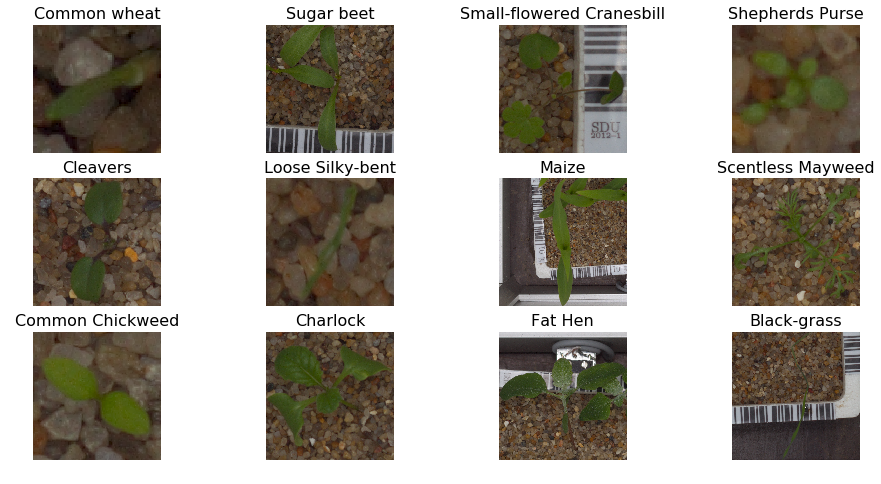

In [19]:
plots.plots(imgs, rows=3, titles=class_names, figsize=(16,8))

### Image size distribution

In [27]:
widths, heights = [], []

for class_name in class_names:
    for f in os.listdir(f'{PATH}train/{class_name}'):
        width, height = Image.open(f'{PATH}/train/{class_name}/{f}').size
        widths.append(width)
        heights.append(height)

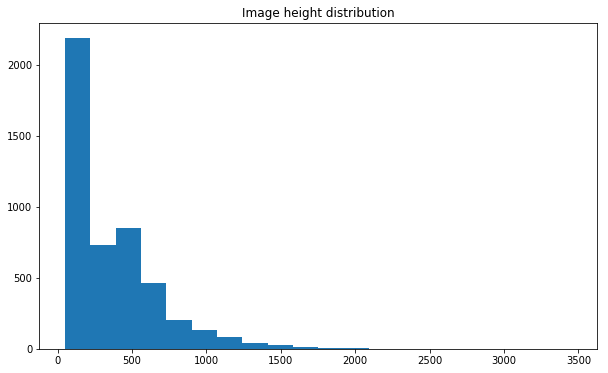

In [49]:
plt.figure(figsize=(10, 6))
plt.title("Image height distribution")
plt.hist(heights, bins=20)
plt.show()

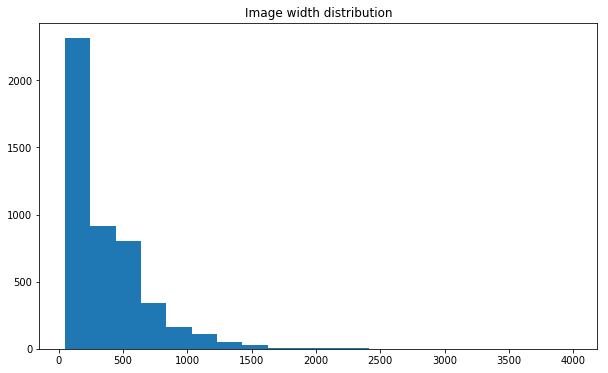

In [48]:
plt.figure(figsize=(10, 6))
plt.title("Image width distribution")
plt.hist(widths, bins=20)
plt.show()

Images are generally quite small and the vast majority are around 100x100.

### Images per class (dataset "balanced-ness")

In [41]:
class_num = {}

# Get number of images per class
for class_name in class_names:
    class_num[class_name] = len(os.listdir(f'{PATH}train/{class_name}'))

# Sort by class length
class_num_sorted = sorted(class_num.items(), key=lambda x: x[1], reverse=True)


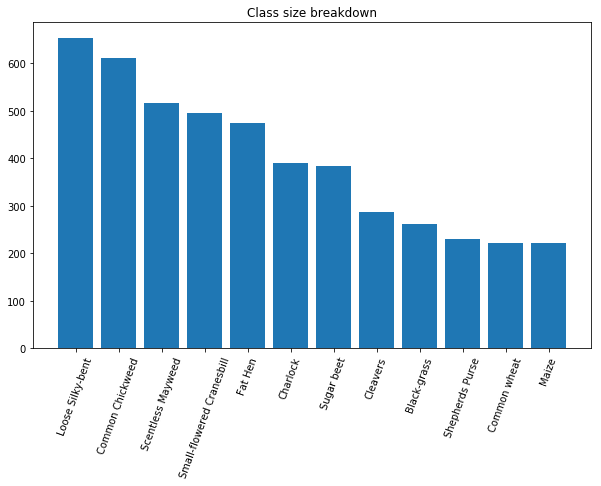

In [51]:
plt.figure(figsize=(10, 6))

labels = [a[0] for a in class_num_sorted]
counts = [a[1] for a in class_num_sorted]

plt.bar(labels, counts, align='center')
plt.xticks(labels, rotation=70)
plt.title("Class size breakdown")
plt.show()

In [52]:
print("Total images:", sum(counts))

Total images: 4750


So, the classes look a little unbalanced and could possibly benefit from some work to balance them. One obvious approach might be to create duplicate augmented images for all the classes with less images than the largest class.

## Create validation set

A simple approach to creating a validation set is to randomly move an image to the validation set, with a probabilty that matches the size of the desired validation set. In this example, i'll aim to move around 10% of the images to the validation set. That should give us a validation set with around 950 images.

In [53]:
random.seed(42)

In [54]:
!mkdir {PATH}valid

I'll create a copy of the train directory, to preserve the original.

In [56]:
!cp -r {PATH}train {PATH}train_limited

In [57]:
all_files = []

for class_dir in os.listdir(f'{PATH}train_limited'):
    os.makedirs(f'{PATH}valid/{class_dir}', exist_ok=True)
    
    for file in os.listdir(f'{PATH}train_limited/{class_dir}'):
        rand = random.random()

        if rand > 0.8:
            shutil.move(f'{PATH}train_limited/{class_dir}/{file}', f'{PATH}valid/{class_dir}/{file}')

In [58]:
PATH

'./data/plant-seedlings-classification/'

## Train using "basic steps"

In [61]:
tfms = transforms.tfms_from_model(
    arch, sz, aug_tfms=transforms.transforms_top_down, max_zoom=1.1)
data = dataset.ImageClassifierData.from_paths(
    PATH,
    trn_name='train_limited', val_name='valid', test_name='test', tfms=tfms)

In [62]:
learn = conv_learner.ConvLearner.pretrained(arch, data, precompute=True)

  0%|          | 0/60 [00:00<?, ?it/s]

/home/ubuntu/src/anaconda3/envs/plant-seedlings/lib/python3.6/site-packages/fastai-0.6-py3.6.egg/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 13/13 [00:06<00:00,  1.95it/s]


### Find learning rate

In [63]:
learn.lr_find()

 70%|███████   | 42/60 [00:01<00:00, 35.37it/s, loss=14.5]


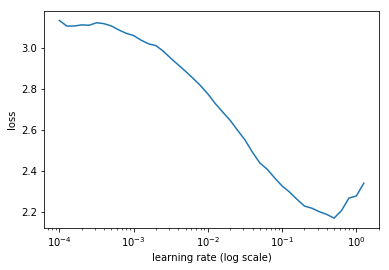

In [64]:
learn.sched.plot()

In [65]:
lr = 0.1

### Train last layer with precomputed activations

In [66]:
learn.fit(lr, 10)

epoch      trn_loss   val_loss   accuracy                 
    0      1.333361   0.771577   0.765273  
    1      0.945175   0.629714   0.817792                  
    2      0.693215   0.526272   0.834941                  
    3      0.505645   0.477886   0.846731                  
    4      0.421069   0.463597   0.846731                  
    5      0.350388   0.586572   0.860665                  
    6      0.290591   0.449703   0.872454                  
    7      0.264498   0.45286    0.860665                  
    8      0.258396   0.434632   0.869239                  
    9      0.227831   0.467335   0.87567                   



[0.4673346357074709, 0.8756698812063611]

### Train last layer with augmentations

In [67]:
learn.precompute = False

In [68]:
learn.fit(lr, 6, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.506304   0.406529   0.877814  
    1      0.487499   0.377221   0.881029                  
    2      0.449735   0.348538   0.894962                  
    3      0.415475   0.361667   0.891747                  
    4      0.411226   0.343926   0.893891                  
    5      0.40619    0.341268   0.892819                  



[0.3412682549171509, 0.8928188634327626]

### Train earlier layers

In [69]:
learn.unfreeze()

In [71]:
learn.lr_find()

 92%|█████████▏| 55/60 [01:25<00:07,  1.56s/it, loss=4.61]

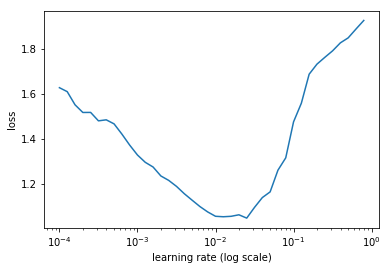

In [72]:
learn.sched.plot()

In [73]:
lr = 0.01
lrs = np.array([lr/9, lr/3, lr])

In [74]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

  2%|▏         | 1/60 [00:06<06:39,  6.77s/it, loss=2.08]
epoch      trn_loss   val_loss   accuracy                  
    0      0.423087   0.276935   0.906752  
    1      0.280126   0.214715   0.937835                  
    2      0.191486   0.20006    0.944266                  
    3      0.176879   0.202057   0.939979                  
    5      0.108546   0.156445   0.953912                  
    6      0.08554    0.157104   0.954984                   



[0.15710393268323533, 0.9549839217435381]

In [75]:
learn.save(f'resnet50_{sz}')

In [76]:
learn.load(f'resnet50_{sz}')

Looks like we're starting to overfit. Will try increasing the image size.

In [78]:
sz = 300
tfms = transforms.tfms_from_model(
    arch, sz, aug_tfms=transforms.transforms_top_down, max_zoom=1.1)
data = dataset.ImageClassifierData.from_paths(
    PATH,
    trn_name='train_limited', val_name='valid', test_name='test', tfms=tfms)

In [79]:
learn.set_data(data)

In [80]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

  2%|▏         | 1/60 [00:06<06:41,  6.81s/it, loss=0.118]
epoch      trn_loss   val_loss   accuracy                  
    0      0.120287   0.147179   0.956056  
    1      0.107078   0.142831   0.953912                  
    2      0.090999   0.141939   0.959271                   
    3      0.08802    0.138441   0.963558                   
    4      0.081874   0.137054   0.961415                   
    5      0.085121   0.138564   0.959271                   
    6      0.082152   0.136107   0.962487                   



[0.13610679112446653, 0.9624866029968343]

In [83]:
learn.save(f'resnet50_{sz}_2')

In [84]:
learn.load(f'resnet50_{sz}_2')

Helped a bit. Try going up in size again.

In [85]:
sz = 400
tfms = transforms.tfms_from_model(
    arch, sz, aug_tfms=transforms.transforms_top_down, max_zoom=1.1)
data = dataset.ImageClassifierData.from_paths(
    PATH,
    trn_name='train_limited', val_name='valid', test_name='test', tfms=tfms)

In [86]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, cycle_save_name=f'resnet50_{sz}_3')

epoch      trn_loss   val_loss   accuracy                   
    0      0.076306   0.135974   0.962487  
    1      0.087006   0.134248   0.962487                   
    2      0.08117    0.13495    0.965702                   
    3      0.076928   0.132484   0.96463                    
    4      0.077252   0.130758   0.96463                    
    5      0.075765   0.130334   0.965702                   
    6      0.076002   0.129528   0.962487                   



[0.1295282036736847, 0.9624866029968343]

In [87]:
learn.save(f'resnet50_{sz}_3')

In [88]:
learn.load(f'resnet50_{sz}_3')

## Evaluation

### f1 score

In [89]:
aug_log_preds, targs = learn.TTA()
log_preds = np.mean(aug_log_preds, axis=0)

In [90]:
f1_score(targs, np.argmax(log_preds, axis=1), average='macro')

0.9605648449726617

### Confusion matrix

In [93]:
cm = confusion_matrix(targs, np.argmax(log_preds, axis=1))

[[ 33   0   0   0   2   0  10   0   0   0   0   0]
 [  0  68   0   0   0   0   0   0   0   0   0   1]
 [  0   0  59   1   1   0   0   0   0   0   0   0]
 [  0   0   0 123   0   0   1   0   0   1   0   0]
 [  0   0   0   0  47   0   0   0   0   0   0   1]
 [  0   0   0   0   0  84   0   0   0   0   0   0]
 [  7   0   0   0   0   0 124   0   0   0   0   0]
 [  0   0   0   0   0   0   0  39   0   0   0   0]
 [  0   0   0   0   0   0   0   0 111   0   0   0]
 [  0   0   0   0   0   0   0   0   2  40   0   0]
 [  1   0   1   0   0   0   0   0   0   0  97   0]
 [  0   0   0   1   0   0   1   0   0   0   0  77]]


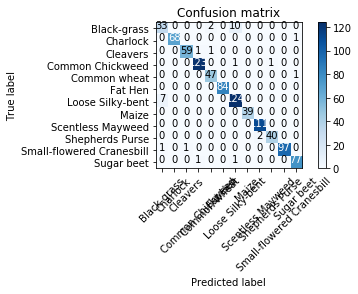

In [99]:
plots.plot_confusion_matrix(cm, classes=learn.data.classes)

## Balance dataset